# Import Python modules

In [1]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
import utils
import networks
from dataloader import ImageDataloader, MultimodalDataloader

# Load processed data

In [2]:
data_dict = torch.load('data/image_csv_processed.pt')
image_dict = torch.load('data/images_processed.pt')

x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_val = data_dict['x_val']
y_val = data_dict['y_val']
x_test = data_dict['x_test']
y_test = data_dict['y_test']

# Fit data to linear regression model

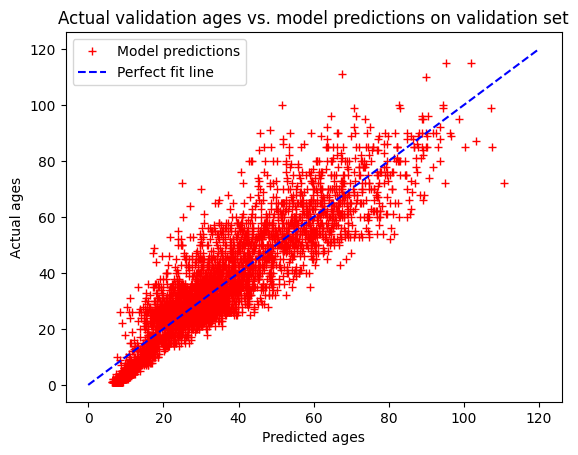

In [3]:
model = LinearRegression()

model = model.fit(x_train, y_train)

pred = model.predict(x_val)

plt.plot(pred, y_val, 'r+', label='Model predictions')
plt.plot([0, 120], [0, 120], 'b--', label='Perfect fit line')
plt.xlabel('Predicted ages')
plt.ylabel('Actual ages')
plt.title('Actual validation ages vs. model predictions on validation set')
plt.legend()

# Train images only with a CNN

In [6]:
x_train_image = image_dict['x_train_image']
x_val_image = image_dict['x_val_image']

# relatively large batch size chosen to ensure faster training
image_batch_size = 32

train_dataloader = ImageDataloader(x = x_train_image, y = y_train, batch_size=image_batch_size, randomize=True)
val_dataloader = ImageDataloader(x = x_val_image, y = y_val, batch_size=image_batch_size, randomize=False)


model = networks.CNNRegression()

# instantiate your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# log your losses
train_losses = []
val_losses = []

# define how many epochs to train on
epochs = 50

# MSELoss is used due to this being a regression task
loss_fn = torch.nn.MSELoss(reduction='none')

train_losses, val_losses = utils.training_loop(train_dataloader, val_dataloader, model, optimizer, epochs, loss_fn, train_losses, val_losses)

100%|██████████| 50/50 [21:48<00:00, 26.17s/it]


# Save checkpoint and losses for model 2

In [7]:
model_state = model.state_dict()

model_2_losses = {'train_losses': train_losses, 'val_losses': val_losses, 'epochs': epochs}

torch.save(model_state, 'model_checkpoints/CNN.ckpt')
torch.save(model_2_losses, 'model_2_losses.pt')

# Train images and CSV features with a multimodal neural network

In [8]:
x_train_image = image_dict['x_train_image']
x_val_image = image_dict['x_val_image']

image_batch_size = 32

train_dataloader = MultimodalDataloader(x = x_train, images=x_train_image, y = y_train, batch_size=image_batch_size, randomize=True)
val_dataloader = MultimodalDataloader(x = x_val, images=x_val_image, y = y_val, batch_size=image_batch_size, randomize=False)

model = networks.MultimodalNetwork()

# instantiate your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# log your losses
train_losses = []
val_losses = []

# define how many epochs to train on
epochs = 50

# MSELoss is used for this regression task
loss_fn = torch.nn.MSELoss(reduction='none')

train_losses, val_losses = utils.training_loop(train_dataloader, val_dataloader, model, optimizer, epochs, loss_fn, train_losses, val_losses, is_model_2=False)

100%|██████████| 50/50 [23:54<00:00, 28.69s/it]


# Save the losses and the model checkpoint

In [9]:
model_state = model.state_dict()
model_3_losses = {'train_losses': train_losses, 'val_losses': val_losses, 'epochs': epochs}

torch.save(model_state, 'model_checkpoints/MultimodalNN.ckpt')
torch.save(model_3_losses, 'model_3_losses.pt')